## 1: Import Pytorch and required Libs

In [1]:
# Import Pytorch and required Libs
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

## 2: Import Dataset from TorchVision: Train_Dataset and Test_Dataset

In [2]:
# Train dataset
train_dataset = torchvision.datasets.FashionMNIST(
    root='.',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [3]:
train_dataset.data.max()

tensor(255, dtype=torch.uint8)

In [4]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

In [5]:
train_dataset.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [6]:
# Test dataset
test_dataset = torchvision.datasets.FashionMNIST(
    root='.',
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

In [7]:
# number of classes
K = len(set(train_dataset.targets.numpy()))
print("number of classes:", K)

number of classes: 10


## 3: Create the model

In [65]:
# Define the model
class CNN(nn.Module):
  def __init__(self, K):
    super(CNN, self).__init__()

    self.conv_layers = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
        nn.ReLU()
    )

    self.dense_layers = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(128 * 2 * 2, 512),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(512, K)
    )

  def forward(self, X):
    out = self.conv_layers(X)
    out = out.view(out.size(0), -1)
    out = self.dense_layers(out)
    return out

In [66]:
# Instantiate the model
model = CNN(K)

In [67]:
# The same model! Using the newly introduced "Flatten"
#model = nn.Sequential(
#     nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2),
#     nn.ReLU(),
#     nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
#     nn.ReLU(),
#     nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
#     nn.ReLU(),
#     nn.Flatten(),
#     nn.Dropout(0.2),
#     nn.Linear(128 * 2 * 2, 512),
#     nn.ReLU(),
#     nn.Dropout(0.2),
#     nn.Linear(512, K)   
# )

### Move the model to CUDA GPU

In [68]:
# model to CUDA gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


CNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
  )
  (dense_layers): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [69]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

### Data Loader for generating batches

In [70]:
# Data Loader
# Useful because it automatically generates batches in the training loop
# and takes care of shuffling

batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

## 4: Train the model and return train_losses and test_losses

In [71]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    model.train()
    t0 = datetime.now()
    train_loss = []
    for inputs, targets in train_loader:
      # move data to GPU
      inputs, targets = inputs.to(device), targets.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(inputs)
      loss = criterion(outputs, targets)

      # Backward and optimize
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    # Get train loss and test loss
    train_loss = np.mean(train_loss)  # a little misleading

    model.eval()
    test_loss = []
    for inputs, targets in test_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss

    dt = datetime.now() - t0
    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
      Test Loss: {test_loss:.4f}, Duration: {dt}')
  
  return train_losses, test_losses

In [72]:
train_losses, test_losses = batch_gd(
    model, criterion, optimizer, train_loader, test_loader, epochs=15)

Epoch 1/15, Train Loss: 0.6642,       Test Loss: 0.4906, Duration: 0:00:14.220142
Epoch 2/15, Train Loss: 0.4492,       Test Loss: 0.4128, Duration: 0:00:13.966879
Epoch 3/15, Train Loss: 0.3900,       Test Loss: 0.3734, Duration: 0:00:14.196958
Epoch 4/15, Train Loss: 0.3512,       Test Loss: 0.3508, Duration: 0:00:14.636971
Epoch 5/15, Train Loss: 0.3232,       Test Loss: 0.3254, Duration: 0:00:14.190909
Epoch 6/15, Train Loss: 0.2989,       Test Loss: 0.3150, Duration: 0:00:13.901431
Epoch 7/15, Train Loss: 0.2803,       Test Loss: 0.3045, Duration: 0:00:13.921697
Epoch 8/15, Train Loss: 0.2617,       Test Loss: 0.3043, Duration: 0:00:14.243185
Epoch 9/15, Train Loss: 0.2471,       Test Loss: 0.2905, Duration: 0:00:14.118655
Epoch 10/15, Train Loss: 0.2347,       Test Loss: 0.2855, Duration: 0:00:14.161398
Epoch 11/15, Train Loss: 0.2212,       Test Loss: 0.2871, Duration: 0:00:13.982815
Epoch 12/15, Train Loss: 0.2083,       Test Loss: 0.2815, Duration: 0:00:14.015136
Epoch 13/15, 

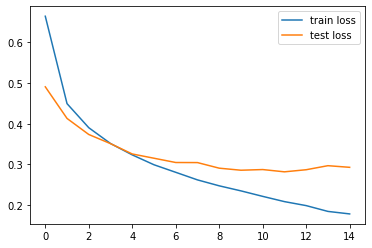

In [75]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

## 5: Evaluate Model Accuracy: Train Accuracy & Test Accuracy

In [79]:
# Accuracy

model.eval()
n_correct = 0.
n_total = 0.
for inputs, targets in train_loader:
  # move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)

  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct / n_total

n_correct  = 0.
n_total = 0.
for inputs, targets in test_loader:
  # move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)

  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct / n_total

print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9545, Test acc: 0.9000


### Evaluate the model with a confusion matrix

In [82]:
# Confusion matrix func
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(conf_mat, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(conf_mat)

  plt.imshow(conf_mat, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = conf_mat.max() / 2.
  for i, j in itertools.product(range(conf_mat.shape[0]), range(conf_mat.shape[1])):
      plt.text(j, i, format(conf_mat[i, j], fmt),
               horizontalalignment="center",
               color="white" if conf_mat[i, j] > thresh else "black")

  plt.tight_layout()
  plt.xlabel('Predicted label')
  plt.ylabel('True label')
  plt.show()

Confusion matrix, without normalization
[[860   1  20  16   2   1  95   0   5   0]
 [  2 975   1  16   3   0   2   0   1   0]
 [ 15   1 863  18  42   0  59   0   2   0]
 [ 12   8  12 904  34   0  28   0   2   0]
 [  0   2  67  22 827   0  80   0   2   0]
 [  0   0   0   2   0 968   0  19   1  10]
 [105   0  58  29  82   0 721   0   5   0]
 [  0   0   0   0   0  12   0 942   0  46]
 [  1   0   5   3   5   2   5   2 975   2]
 [  1   0   0   0   0   2   0  31   1 965]]


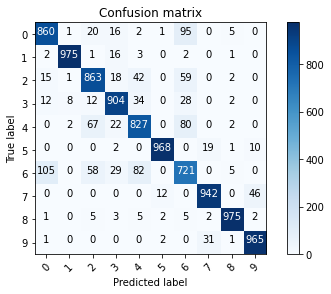

In [87]:
# get all predictions in an array and plot confusion matrix

X_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()
pred_test = np.array([])
for inputs, targets in test_loader:
  # move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  _, predictions = torch.max(outputs, 1)

  # update pred_test
  pred_test = np.concatenate((pred_test, predictions.cpu().numpy()))

conf_mat = confusion_matrix(y_test, pred_test)
plot_confusion_matrix(conf_mat, list(range(K)))

## 6: Predicted results: Show True-classified & Misclassified Example

In [88]:
# Label mapping
labels = '''T-shirt/top
Trouser
Pullover
Dress
Coat
Sandal
Shirt
Sneaker
Bag
Ankle boot'''.split("\n")

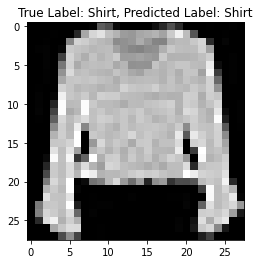

In [96]:
# Show True-classified example
pred_test = pred_test.astype(np.uint8)
true_classified_idx = np.where(pred_test == y_test)[0]
i = np.random.choice(true_classified_idx)
plt.imshow(X_test[i], cmap='gray')
plt.title("True Label: %s, Predicted Label: %s" % (labels[y_test[i]], labels[pred_test[i]]));

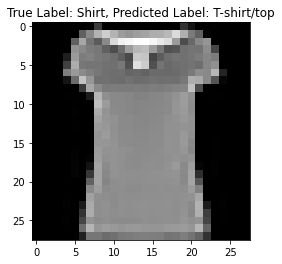

In [98]:
# Show Misclassified example
pred_test = pred_test.astype(np.uint8)
misclassified_idx = np.where(pred_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(X_test[i], cmap='gray')
plt.title("True Label: %s, Predicted Label: %s" % (labels[y_test[i]], labels[pred_test[i]]));